In [1]:
import matplotlib.pyplot as plt 
from scipy import stats
import numpy as np
import pandas as pd
from datetime import datetime 
import netCDF4
import xarray as xr

exploring mms data

good resource: https://www.earthinversion.com/utilities/reading-NetCDF4-data-in-python/

In [2]:
# # using NETCDF4

# data_floc = 'mms-data' # directory for data file location
# data_fname_2015_2019 = 'mms1_imef_srvy_l2_5sec_20150901000000_20190101000000' # file name
# dfile = data_floc+'/'+data_fname_2015_2019+'.nc' # complete path to file

# # get dataset
# mms_dat1 = netCDF4.Dataset(dfile)   # NETCDF4
# # mms_dat1 = xr.open_dataset(dfile) # xarray

# # print vars
# print(mms_dat1.variables.keys()) # NETCDF4
# # mms_dat1.data_vars # xarray

# # individually acces var
# e = mms_dat1.variables['E_EDP'] 
# t = mms_dat1.variables['time'] 

# # get shape, dimension of variable
# print(e.dimensions)
# print(e.shape)

# # pull values from variable
# e = mms_dat1.variables['E_EDI'][:]
# print(e)


In [3]:
# locate data
data_floc = 'mms-data' # directory for data file location
data_fname_2015_2019 = 'mms1_imef_srvy_l2_5sec_20150901000000_20190101000000' # file name
dfile = data_floc+'/'+data_fname_2015_2019+'.nc' # complete path to file

# read dataset
dat = xr.open_dataset(dfile)

# get time
t = dat['time'].values

# get start date in short format
t0 = pd.to_datetime(t[0]).strftime('%m/%d/%Y')

# get end date in short format
tf = pd.to_datetime(t[-1]).strftime('%m/%d/%Y')

# check
print(f" data start: {t0}, data end: {tf}")


 data start: 09/01/2015, data end: 12/31/2018


In [4]:
# isolate E-field from diff. MMS instruments
edp = dat['E_EDP'][:,:,0].drop(['cart',]).rename({'E_index': 'cart'}).assign_coords({'cart': ['x', 'y', 'z']})
edi = dat['E_EDI']
dis = dat['E_DIS']
des = dat['E_DES']


# # pull values
# e = e.loc[:,'x'].values
# # remove values greater than +/-1000 [mV/m]
# e[abs(e) >= 1000] = np.nan
# # plots
#e.loc[:,'x'].plot()
#plt.plot(t,ex)



In [5]:

def plot_efield_overview(ax, edat, t):
    
    instr_name = str(edat.name[-3:7])   # instrument name
    instr_ltX = "$E_{"+instr_name+"}$"  # name in LaTex formatting
    
    # pull data
    ex = edat.loc[:,'x'].values # Ex
    ey = edat.loc[:,'y'].values # Ey
    ez = edat.loc[:,'z'].values # Ez
    
    # remove outlying/bad values
    for arr in [ex,ey,ez]:
        arr[abs(arr) >= 1000] = np.nan
    
    # plot E-field over time
    ax.plot(t,ex, c='r', linewidth=1, label='$E_x$')
    ax.plot(t,ey, c='g', linewidth=1, label='$E_y$')
    ax.plot(t,ez, c='b', linewidth=1, label='$E_z$')
    ax.set_ylabel(f"{instr_ltX} [mV/m]")
    
    # x-axis tick label rotation to fit length of dates
    # ax.set_xticks(ax.get_xticks())
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # plot legend
    ax.legend(bbox_to_anchor=(1, 1))
        

# (A/N) run for DIS instrument

# # example: overview plot for DIS intrument
# fig, ax = plt.subplots(1, figsize=(8, 2))
# plot_efield_overview(ax,dis,t)
# # x-axis tick label rotation to fit length of dates
# #ax.set_xticks(ax.get_xticks())
# ax.set_xticks(ax.get_xticks().tolist())
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


In [6]:
# (A/N) this code creates plot for all MMS instruments;
# (A/N) runs a bit slow!

# fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 10))
# fig.tight_layout()
# # fig.suptitle(f'Overview of {sdate} Storm')
# plot_efield_overview(ax[0],edi,t)
# plot_efield_overview(ax[1],edp,t)
# plot_efield_overview(ax[2],dis,t)
# plot_efield_overview(ax[3],des,t)

# # x-axis tick label rotation to fit length of dates
# # ax[3].set_xticks(ax[3].get_xticks().tolist())
# ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45, ha='right')
    


Comparison of electric field values for the EDI and EDP MMS instruments from 09/01/2015 to 12/31/2018. E-field values in units [mV/m].
Plotted datapoints are grouped by hexagonal bins, or “hexbins,” such that each hexbin denotes the log number of points, log(N), in it.


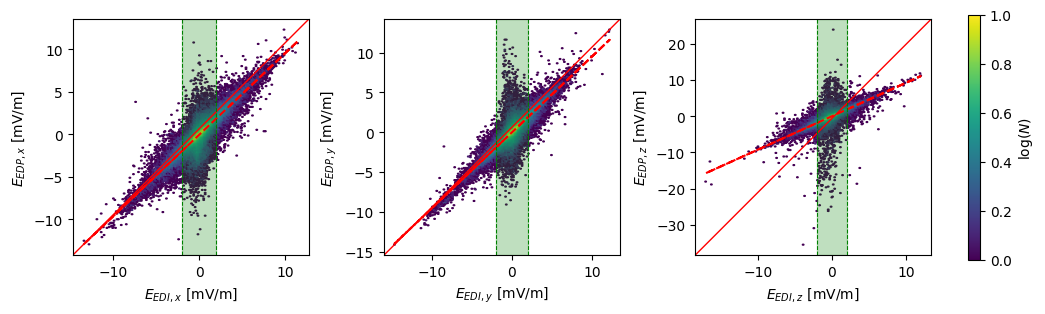

In [7]:

def plot_efield_comp(axs, ef1, ef2, c='k', hex=False, **kwargs):
    
    instr1 = "$E_{"+str(ef1.name[-3:7])+"}$" # instrument 1 name
    instr2 = "$E_{"+str(ef2.name[-3:7])+"}$" # instrument 2 name
    
    # get coordinates
    ef1_coord = [ef1.loc[:,'x'].values, ef1.loc[:,'y'].values, ef1.loc[:,'z'].values]
    ef2_coord = [ef2.loc[:,'x'].values, ef2.loc[:,'y'].values, ef2.loc[:,'z'].values]
    coord = ['x','y','z']
    
    # remove outliers
    for arr in ef1_coord:
        arr[abs(arr) >= 1000] = np.nan
        
    for arr in ef2_coord:
        arr[abs(arr) >= 1000] = np.nan
        
    
    # scatter plot: efield comparison
    for i in range(0,3):
        if hex == True:
            axs[i].hexbin(ef1_coord[i], ef2_coord[i], gridsize=(150, 150), bins="log")
        else:
            axs[i].scatter(ef1_coord[i], ef2_coord[i], marker='x',color=c,linewidths=0.5, **kwargs)
        
        
        idx = np.isfinite(ef1_coord[i]) & np.isfinite(ef2_coord[i]) # polyfit only works without nans in data; filter where values are finite
        z = np.polyfit(ef1_coord[i][idx], ef2_coord[i][idx], 1)
        p = np.poly1d(z)
        z = axs[i].plot(ef1_coord[i][idx], p(ef1_coord[i][idx]), "r--")
        
        axs[i].set_xlabel(f"{instr1}$_{{,{coord[i]}}}$ [mV/m]")
        axs[i].set_ylabel(f"{instr2}$_{{,{coord[i]}}}$ [mV/m]")
        
        # option with flexibility 
        # p1 = max(max(ef1_coord[i]), max(ef2_coord[i]))
        # p2 = min(min(ef1_coord[i]), min(ef2_coord[i]))
        # print(ef1_coord[i])
        # axs[i].plot([p1, p2], [p1, p2], 'b-')
        


    # identity line
    for ax in axs:
        ax.plot([0,1],[0,1], color='r', linewidth=1, alpha=1, transform=ax.transAxes)
        
        # axs[0].fill_between(means.ix[:,0], means.ix[:,1]-stds.ix[:,0], means.ix[:,1]+stds.ix[:,0])
        #ax.plot([0,1],[0,1]- np.std([0,1]), color='r', linewidth=1, alpha=1, transform=ax.transAxes)
        



        
    # enforce square-shaped plots
    for ax in axs:
        ax.set_box_aspect(1)

    # alternative, makes line start/stop just before end of plot
    # for ax in axs:
    #     lims = [
    #     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #     ]

    #     # identity line
    #     ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    
    # generate caption
    t = ef1['time'].values
    t0 = pd.to_datetime(t[0]).strftime('%m/%d/%Y')
    tf = pd.to_datetime(t[-1]).strftime('%m/%d/%Y')
    print(f"Comparison of electric field values for the {ef1.name[-3:7]} and {ef2.name[-3:7]} MMS instruments from {t0} to {tf}. E-field values in units [mV/m]." )
    if hex==True:
        print("Plotted datapoints are grouped by hexagonal bins, or “hexbins,” such that each hexbin denotes the log number of points, log(N), in it.")


# example: instrument E-field comparison
fig, axs = plt.subplots(1,3, figsize=(10,10))
myplt = plot_efield_comp(axs, edi, edp, hex=True)

# show irregularilty
width = 2
for ax in axs:
    c_shade = 'g'
    ax.axvline(x=width, color=c_shade, linestyle='--', linewidth=0.75)
    ax.axvline(x=-width, color=c_shade, linestyle='--', linewidth=0.75)
    ax.axvspan(-width, width, alpha=0.25, color=c_shade)


fig.tight_layout()

# include when hex=True for colorbar
fig.colorbar(myplt, ax=axs, label="log($N$)", fraction=0.0135, pad=0.04) 



In [8]:
#edi_df = edi.loc[:,'x'].values.to_dataframe()
df = pd.DataFrame(edi.loc[:,'x'].values)
edi['time'][-1]

<xarray.DataArray 'time' ()>
array('2018-12-31T23:59:55.000000000', dtype='datetime64[ns]')
Coordinates:
    dt_minus  timedelta64[ns] ...
    dt_plus   timedelta64[ns] ...
    time      datetime64[ns] 2018-12-31T23:59:55

In [9]:
# locate data
data_floc = 'mms-data' # directory for data file location
data_fname_2015_2019 = 'mms1_imef_srvy_l2_5sec_20150901000000_20190101000000' # file name
dfile = data_floc+'/'+data_fname_2015_2019+'.nc' # complete path to file

# read dataset
dat = xr.open_dataset(dfile)

# get time
t = dat['time'].values
t0 = pd.to_datetime(t[0]).strftime('%m/%d/%Y') # get start date in short format
tf = pd.to_datetime(t[-1]).strftime('%m/%d/%Y') # get end date in short format
print(f" data start: {t0}, data end: {tf}") # check

# isolate E-field from diff. MMS instruments
edp = dat['E_EDP'][:,:,0].drop(['cart',]).rename({'E_index': 'cart'}).assign_coords({'cart': ['x', 'y', 'z']})
edi = dat['E_EDI']
dis = dat['E_DIS']



# for i in range(0,len(edi.values)):
    
#     e1_coords = edi.values[i]
#     e2_coords = edp.values[i]
    
    


 data start: 09/01/2015, data end: 12/31/2018


In [10]:
'''Making a merged plot
'''

# locate data
data_floc = 'mms-data' # directory for data file location
data_fname_mms1_2015_2019 = 'mms1_imef_srvy_l2_5sec_20150901000000_20190101000000' # file name
data_fname_mms1_2019_2022 = 'mms1_imef_srvy_l2_5sec_20190101000000_20220901000000'
data_fname_mms2_2015_2019= 'mms2_imef_srvy_l2_5sec_20150901000000_20190101000000'
data_fname_mms2_2019_2022 = 'mms2_imef_srvy_l2_5sec_20190101000000_20220901000000'

dfile_mms1_15_19 = data_floc+'/'+data_fname_mms1_2015_2019+'.nc' # complete path to file
dfile_mms2_15_19 = data_floc+'/'+data_fname_mms1_2015_2019+'.nc' # complete path to file
dfile_mms1_19_22 = data_floc+'/'+data_fname_mms1_2019_2022+'.nc' # complete path to file
dfile_mms2_19_22 = data_floc+'/'+data_fname_mms1_2019_2022+'.nc' # complete path to file

# read dataset
dat_mms1_15_19 = xr.open_dataset(dfile_mms1_15_19)
dat_mms2_15_19 = xr.open_dataset(dfile_mms2_15_19)
dat_mms1_19_22 = xr.open_dataset(dfile_mms1_19_22)
dat_mms2_19_22 = xr.open_dataset(dfile_mms2_19_22)
t_2015_2019 = dat_mms1_15_19['time']
t_2019_2022 = dat_mms1_19_22['time']

# isolate E-field from diff. MMS instruments
edi_1_15_19 = dat_mms1_15_19['E_EDI']
dis_1_15_19 = dat_mms1_15_19['E_DIS']
edi_2_15_19 = dat_mms2_15_19['E_EDI']
dis_2_15_19 = dat_mms2_15_19['E_DIS']
edi_1_19_22 = dat_mms1_19_22['E_EDI']
dis_1_19_22 = dat_mms1_19_22['E_DIS']
edi_2_19_22 = dat_mms2_19_22['E_EDI']
dis_2_19_22 = dat_mms2_19_22['E_DIS']
edp_1_19_22 = dat_mms1_19_22['E_EDP']



# fig, axs = plt.subplots(1,3, figsize=(10,10))
# plot_efield_comp(axs, edi_1a, dis_1a, label="mms1")
# plot_efield_comp(axs, edi_2a, dis_2a, c='b', label="mms1")
# plt.legend()
# # for ax in axs:
# #     ax.legend()
# fig.tight_layout()


In [11]:
# # (A/N) this code creates plot for all MMS instruments 2019-2022;
# # (A/N) runs a bit slow!

# fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(8, 10))
# fig.tight_layout()
# # fig.suptitle(f'Overview of {sdate} Storm')
# plot_efield_overview(ax[0],edi_1_19_22,t_2019_2022)
# plot_efield_overview(ax[1],edi_1_19_22,t_2019_2022)
# plot_efield_overview(ax[2],dis_1_19_22,t_2019_2022)

# # x-axis tick label rotation to fit length of dates
# # ax[3].set_xticks(ax[3].get_xticks().tolist())
# ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right')

In [12]:
'''Making a merged plot
'''

# locate data
data_floc = 'mms-data' # directory for data file location
data_fname_mms1_2015_2019 = 'mms1_imef_srvy_l2_5sec_20150901000000_20190101000000' # file name
data_fname_mms1_2019_2022 = 'mms1_imef_srvy_l2_5sec_20190101000000_20220901000000'
data_fname_mms2_2015_2019= 'mms2_imef_srvy_l2_5sec_20150901000000_20190101000000'
data_fname_mms2_2019_2022 = 'mms2_imef_srvy_l2_5sec_20190101000000_20220901000000'

dfile_mms1_2015_2019 = data_floc+'/'+data_fname_mms1_2015_2019+'.nc' # complete path to file
dfile_mms2_2015_2019 = data_floc+'/'+data_fname_mms1_2015_2019+'.nc' # complete path to file
dfile_mms1_2019_2022 = data_floc+'/'+data_fname_mms1_2019_2022+'.nc' # complete path to file
dfile_mms2_2019_2022 = data_floc+'/'+data_fname_mms1_2019_2022+'.nc' # complete path to file

# read datasets
dat_mms1_2015_2019 = xr.open_dataset(dfile_mms1_2015_2019)
dat_mms2_2015_2019 = xr.open_dataset(dfile_mms2_2015_2019)
dat_mms1_2019_2022 = xr.open_dataset(dfile_mms1_2019_2022)
dat_mms2_2019_2022 = xr.open_dataset(dfile_mms2_2019_2022)

# combine datasets for 2015-2022
# xr.merge([dat_mms1_2015_2019, dat_mms1_2019_2022], compat="override")

In [39]:
#newarr = xr.concat([dat_mms1_2015_2019, dat_mms1_2019_2022], dim='E_EDI')
# d = {'col1': [1, 2], 'col2': [3, 4]}
# df = pd.DataFrame(data=d)
# df

ez_edi = dat_mms1_2015_2019['E_EDI'].loc[:,'z'].values
e_update = dat_mms1_2015_2019['E_EDP'][:,:,0].drop(['cart',]).rename({'E_index': 'cart'}).assign_coords({'cart': ['x', 'y', 'z']})
ez_edp = e_update.loc[:,'z'].values
t = dat_mms1_2015_2019['time'].values

# remove outliers
for arr in [ez_edi, ez_edp]:
    arr[abs(arr) >= 1000] = np.nan
    
d = {'EDI_z': ez_edi, 'EDP_z': ez_edp, 'time': t}
df = pd.DataFrame(data=d)
df

,EDI_z,EDP_z,time
0,NaN,NaN,2015-09-01 00:00:00
1,NaN,NaN,2015-09-01 00:00:05
2,NaN,-2.991203,2015-09-01 00:00:10
3,NaN,-2.384261,2015-09-01 00:00:15
4,NaN,-2.732247,2015-09-01 00:00:20
...,...,...,...
21047035,NaN,NaN,2018-12-31 23:59:35
21047036,NaN,NaN,2018-12-31 23:59:40
21047037,NaN,NaN,2018-12-31 23:59:45
21047038,NaN,NaN,2018-12-31 23:59:50


In [47]:
width = 2
filtr_dist =  df[(df['EDI_z'] <= 2) & (df['EDI_z'] >= -2) & df['EDI_z'].notna()]
print(filtr_dist.quantile([0.25,0.5,0.75]))
filtr_dist

         EDI_z     EDP_z
0.25 -0.437543 -0.463102
0.50 -0.121138 -0.125222
0.75  0.094080  0.116613


/var/folders/8l/y30_j6_97qj5rc4x992936vr0000gp/T/ipykernel_56750/2004834200.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(filtr_dist.quantile([0.25,0.5,0.75]))


,EDI_z,EDP_z,time
45,-1.133328,-0.762028,2015-09-01 00:03:45
47,-0.869285,0.010998,2015-09-01 00:03:55
51,-0.981389,-0.035419,2015-09-01 00:04:15
57,-1.013342,-0.572211,2015-09-01 00:04:45
58,-0.893569,-0.752066,2015-09-01 00:04:50
...,...,...,...
21026196,1.746197,2.031070,2018-12-30 19:03:00
21026204,-0.845809,-1.502312,2018-12-30 19:03:40
21026206,-1.340916,-1.770613,2018-12-30 19:03:50
21026209,-1.020251,-2.085946,2018-12-30 19:04:05


(array([3.00000e+00, 1.00000e+00, 3.00000e+00, 7.00000e+00, 8.00000e+00,
        1.60000e+01, 1.30000e+01, 2.30000e+01, 1.90000e+01, 2.50000e+01,
        2.80000e+01, 6.30000e+01, 2.38000e+02, 7.12000e+02, 2.22420e+04,
        3.31226e+05, 4.39790e+04, 1.25300e+03, 1.69000e+02, 5.80000e+01,
        4.80000e+01, 3.00000e+01, 4.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-26.24757619, -24.57660823, -22.90564028, -21.23467232,
        -19.56370436, -17.89273641, -16.22176845, -14.55080049,
        -12.87983253, -11.20886458,  -9.53789662,  -7.86692866,
         -6.19596071,  -4.52499275,  -2.85402479,  -1.18305684,
          0.48791112,   2.15887908,   3.82984703,   5.50081499,
          7.17178295,   8.8427509 ,  10.51371886,  12.18468682,
         13.85565477,  15.52662273,  17.19759069,  18.86855864,
         20.5395266 ,  22.21049456,  23.88146251]),
 <BarContainer object of 30 artists>)

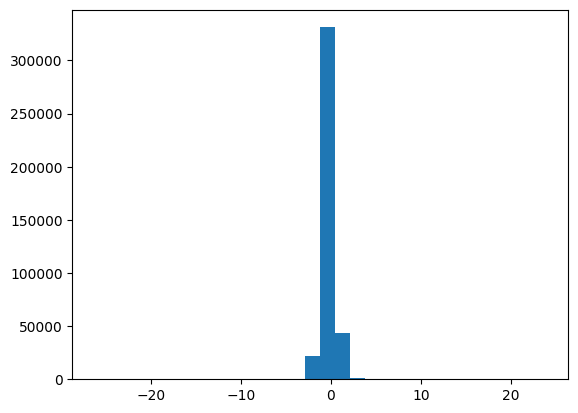

In [41]:
plt.hist(filtr_dist['EDP_z'], bins=30)


/var/folders/8l/y30_j6_97qj5rc4x992936vr0000gp/T/ipykernel_56750/4259497847.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(filtr_dist.quantile([0.25,0.5,0.75, 0.85]))


         EDI_z     EDP_z
0.25 -0.437543 -0.463102
0.50 -0.121138 -0.125222
0.75  0.094080  0.116613
0.85  0.310596  0.341621


Text(0, 0.5, 'EDP_Z')

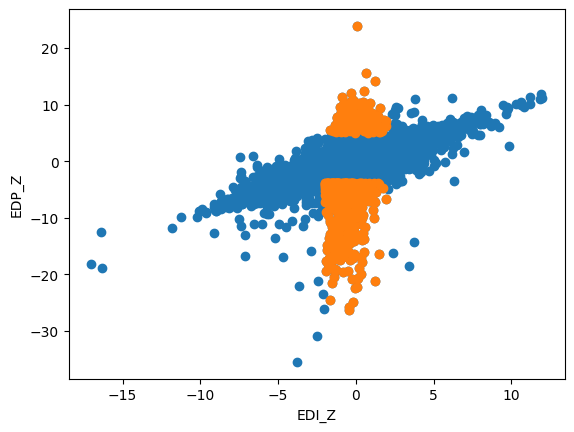

In [72]:
print(filtr_dist.quantile([0.25,0.5,0.75, 0.85]))
qlim = 0.116613

# calculate IQR for column A
Q1 = filtr_dist['EDP_z'].quantile(0.25)
Q3 = filtr_dist['EDP_z'].quantile(0.99)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outs = filtr_dist[(filtr_dist['EDP_z'] < Q1 - threshold * IQR) | (filtr_dist['EDP_z'] > Q3 + threshold * IQR)]

# outs =  filtr_dist[(filtr_dist['EDP_z'] <= qlim) & (filtr_dist['EDP_z'] >= -1*qlim)]
plt.scatter(df['EDI_z'], df['EDP_z'])
plt.scatter(outs['EDI_z'], outs['EDP_z'])
plt.xlabel("EDI_Z")
plt.ylabel("EDP_Z")




AttributeError: 'Series' object has no attribute 'iterrows'

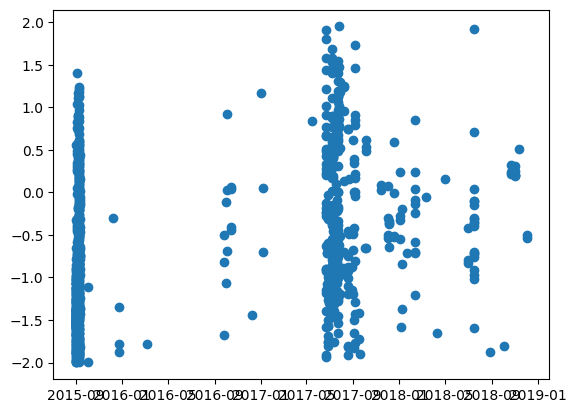

In [79]:
plt.scatter(outs['time'],outs['EDI_z'])
for ix, row in outs['time'].iterrows():
    plt.fill_between(row, 3, color='blue', alpha=.5)

In [80]:
df['time'].isin(outs['time'])

In [ ]:
newarr

NameError: name 'newarr' is not defined

Comparison of electric field values for the EDI and EDP MMS instruments from 09/01/2015 to 12/31/2018. E-field values in units [mV/m].


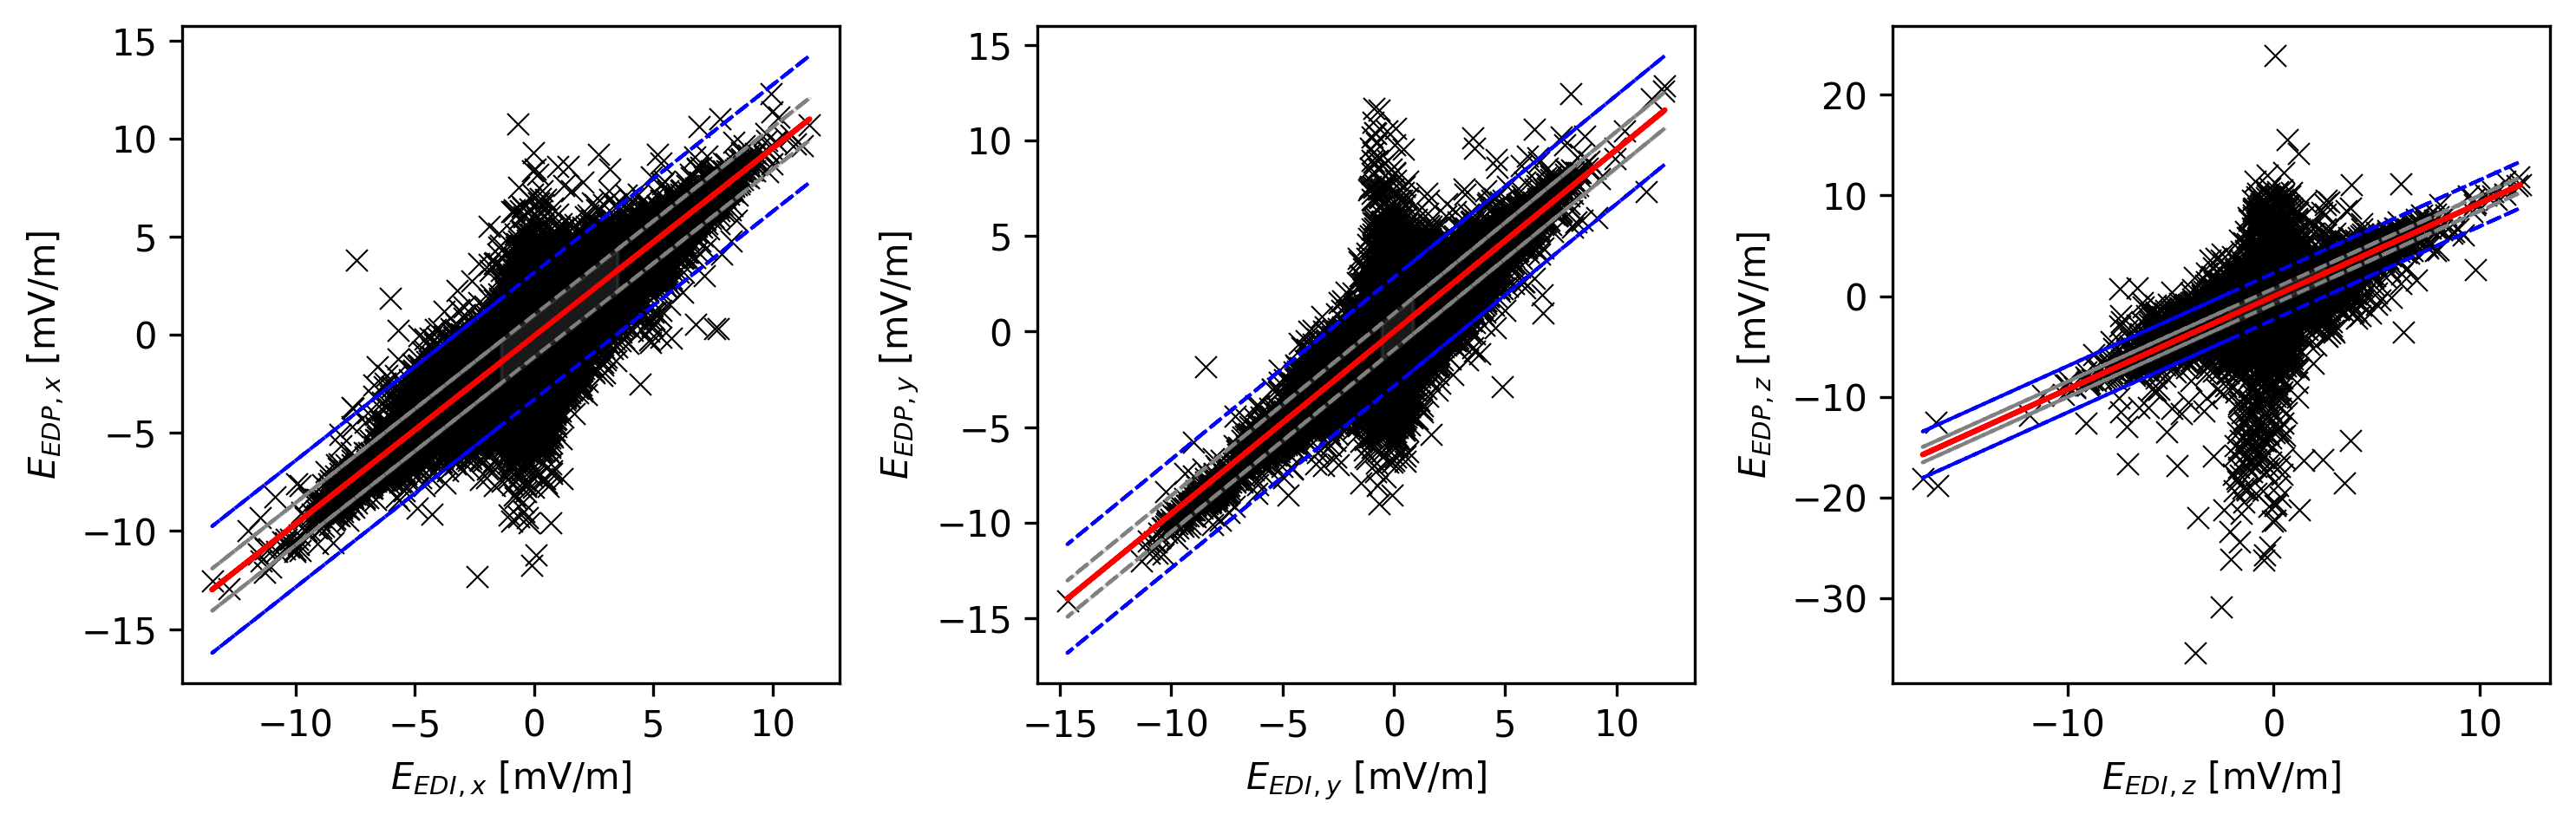

In [ ]:
def plot_efield_comp(axs, ef1, ef2, c='k', hex=False, **kwargs):
    
    instr1 = "$E_{"+str(ef1.name[-3:7])+"}$" # instrument 1 name
    instr2 = "$E_{"+str(ef2.name[-3:7])+"}$" # instrument 2 name
    
    # get coordinates
    ef1_coord = [ef1.loc[:,'x'].values, ef1.loc[:,'y'].values, ef1.loc[:,'z'].values]
    ef2_coord = [ef2.loc[:,'x'].values, ef2.loc[:,'y'].values, ef2.loc[:,'z'].values]
    coord = ['x','y','z']
    
    # remove outliers
    for arr in ef1_coord:
        arr[abs(arr) >= 1000] = np.nan
        
    for arr in ef2_coord:
        arr[abs(arr) >= 1000] = np.nan
        
    
    # scatter plot: efield comparison
    for i in range(0,3):
        if hex == True:
            axs[i].hexbin(ef1_coord[i], ef2_coord[i], gridsize=(150, 150), bins="log")
        else:
            axs[i].scatter(ef1_coord[i], ef2_coord[i], marker='x',color=c,linewidths=0.5, **kwargs)
        
        #fit linear regression via least squares
        idx = np.isfinite(ef1_coord[i]) & np.isfinite(ef2_coord[i]) # polyfit only works without nans in data; filter where values are finite
        z = np.polyfit(ef1_coord[i][idx], ef2_coord[i][idx], 1)
        p = np.poly1d(z)
        poly_x = ef1_coord[i][idx]
        poly_y = p(ef1_coord[i][idx])
        axs[i].plot(poly_x, poly_y, "r-")
        axs[i].plot(poly_x, poly_y - np.std(poly_y), c='gray', linestyle='--', linewidth=1)
        axs[i].plot(poly_x, poly_y + np.std(poly_y), c='gray',linestyle='--', linewidth=1)
        msig = 3
        axs[i].plot(poly_x, poly_y - msig*np.std(poly_y), c='b', linestyle='--', linewidth=1)
        axs[i].plot(poly_x, poly_y + msig*np.std(poly_y), c='b',linestyle='--', linewidth=1)
        axs[i].fill_between(poly_x, poly_y + np.std(poly_y), poly_y -np.std(poly_y), color='gray', alpha=0.2)
        #plt.scatter(x, y + np.std(y), c='y')
        
        # axs[i].plot(ef1_coord[i][idx], p(ef1_coord[i][idx]) + delta, "g--")
        # axs[i].plot(ef1_coord[i][idx], p(ef1_coord[i][idx]) - delta, "g--")
        # #z_3 = axs[i].fill_between(ef1_coord[i][idx], p(ef1_coord[i][idx]) - delta, p(ef1_coord[i][idx]) + delta, color='g', alpha=0.1)

        
        axs[i].set_xlabel(f"{instr1}$_{{,{coord[i]}}}$ [mV/m]")
        axs[i].set_ylabel(f"{instr2}$_{{,{coord[i]}}}$ [mV/m]")
        
        
    # enforce square-shaped plots
    for ax in axs:
        ax.set_box_aspect(1)
    
    # generate caption
    t = ef1['time'].values
    t0 = pd.to_datetime(t[0]).strftime('%m/%d/%Y')
    tf = pd.to_datetime(t[-1]).strftime('%m/%d/%Y')
    print(f"Comparison of electric field values for the {ef1.name[-3:7]} and {ef2.name[-3:7]} MMS instruments from {t0} to {tf}. E-field values in units [mV/m]." )
    if hex==True:
        print("Plotted datapoints are grouped by hexagonal bins, or “hexbins,” such that each hexbin denotes the log number of points, log(N), in it.")


# example: instrument E-field comparison
fig, axs = plt.subplots(1,3, figsize=(10,10), dpi=300)
myplt = plot_efield_comp(axs, edi, edp, hex=False)
fig.tight_layout()


In [ ]:
# locate data
data_floc = 'mms-data' # directory for data file location
data_fname_2015_2019 = 'mms1_imef_srvy_l2_5sec_20150901000000_20190101000000' # file name
dfile = data_floc+'/'+data_fname_2015_2019+'.nc' # complete path to file

# read dataset
dat = xr.open_dataset(dfile)

# get time
t = dat['time'].values
t0 = pd.to_datetime(t[0]).strftime('%m/%d/%Y') # get start date in short format
tf = pd.to_datetime(t[-1]).strftime('%m/%d/%Y') # get end date in short format
print(f" data start: {t0}, data end: {tf}") # check

# isolate E-field from diff. MMS instruments
edp = dat['E_EDP'][:,:,0].drop(['cart',]).rename({'E_index': 'cart'}).assign_coords({'cart': ['x', 'y', 'z']})
edi = dat['E_EDI']
dis = dat['E_DIS']

 data start: 09/01/2015, data end: 12/31/2018


Text(0, 0.5, 'EDP')

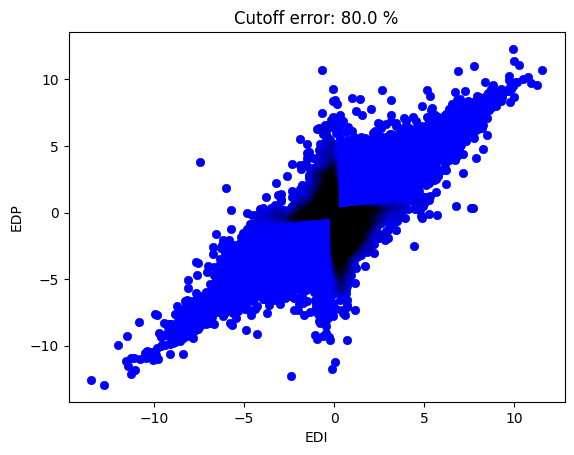

In [ ]:
edi_x = edi.loc[:,'x'].values
edp_x = edp.loc[:,'x'].values

# remove outliers
edi_x[abs(edi_x) >= 1000] = np.nan
edp_x[abs(edp_x) >= 1000] = np.nan


# % error
def perror(theory, observed):
    ans = (theory-observed)/theory
    return ans

err = []
for i in range(0, len(edi_x)):
    err.append(perror(edi_x[i], edp_x[i]))

err_cutoff = 0.8
indx = [i for i, x in enumerate(err) if x >= err_cutoff]

plt.scatter(edi_x, edp_x, linewidths=0.5, c='b',alpha = 1) # normal
plt.scatter(edi_x[indx], edp_x[indx], c='k',linewidths=0.5,alpha = 0.04) # constrained by error
plt.title(f"Cutoff error: {err_cutoff*100} %")
plt.xlabel(f"EDI")
plt.ylabel(f"EDP")






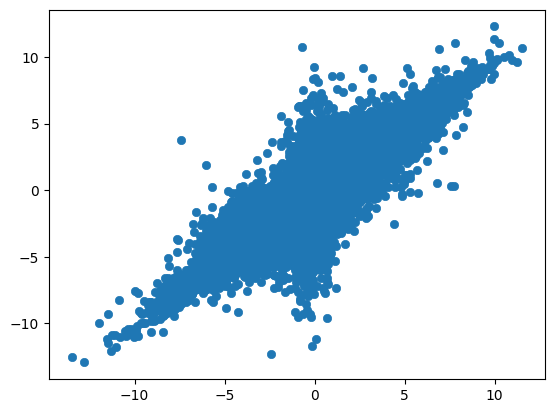